## Regret Analysis of OFL - \<Performance Experiments\>

### 1. Environment Setting

In [2]:
import  torch
import  numpy as np
import  matplotlib.pyplot as plt
from    keras import datasets
import  import_ipynb

from RegretBound import opt_param
from data import pull_data
from model import FL_Model

K = 1000        # Number of clients
D = 34826       # number of parameters
P = 0.01        # Com. overhead reduction rate from FedOGD
L = 1           # Local training time (Batch Size)

s, _, b, p = opt_param(P, D, show_result=False)

FedOGD_loss = []
OFedAvg_loss = []
OFedAQ_loss = []

FedOGD_acc = []
OFedAvg_acc = []
OFedAQ_acc = []

### 2. Experiment Setting

In [3]:
### Running Time (~2min, iMac 27(2019)) ###

#MNIST
x_train, y_train, _, _= pull_data()

FedOGD = FL_Model(K, False, 1, L)
OFedAvg = FL_Model(K, False, P, L)
#Synthetic data

2022-10-03 00:27:56.187306: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 3. Training

In [4]:
#OFedAvg iter 30 -> 3hr

for iter in range(30):
    for i in range(60):
        loss, acc = OFedAvg.train(x_train[K*L*i : K*L*(i+1)], y_train[K*L*i : K*L*(i+1)])
        OFedAvg_loss.append(loss)
        OFedAvg_acc.append(acc)
        if i % 10 == 0:
            print('%d/60' %(i))

0/60
10/60
20/60
30/60
40/60
50/60
0/60
10/60
20/60
30/60
40/60
50/60
0/60
10/60
20/60
30/60
40/60
50/60
0/60
10/60
20/60
30/60
40/60
50/60
0/60
10/60
20/60
30/60
40/60
50/60
0/60
10/60
20/60
30/60
40/60
50/60
0/60
10/60
20/60
30/60
40/60
50/60
0/60
10/60
20/60
30/60
40/60
50/60
0/60
10/60
20/60
30/60
40/60
50/60
0/60
10/60
20/60
30/60
40/60
50/60
0/60
10/60
20/60
30/60
40/60
50/60
0/60
10/60
20/60
30/60
40/60
50/60
0/60
10/60
20/60
30/60
40/60
50/60
0/60
10/60
20/60
30/60
40/60
50/60
0/60
10/60
20/60
30/60
40/60
50/60
0/60
10/60
20/60
30/60
40/60
50/60
0/60
10/60
20/60
30/60
40/60
50/60
0/60
10/60
20/60
30/60
40/60
50/60
0/60
10/60
20/60
30/60
40/60
50/60
0/60
10/60
20/60
30/60
40/60
50/60
0/60
10/60
20/60
30/60
40/60
50/60
0/60
10/60
20/60
30/60
40/60
50/60
0/60
10/60
20/60
30/60
40/60
50/60
0/60
10/60
20/60
30/60
40/60
50/60
0/60
10/60
20/60
30/60
40/60
50/60
0/60
10/60
20/60
30/60
40/60
50/60
0/60
10/60
20/60
30/60
40/60
50/60
0/60
10/60
20/60
30/60
40/60
50/60
0/60
10/60
20/60
30/

In [ ]:
# Save Result

### 4. Plot Result

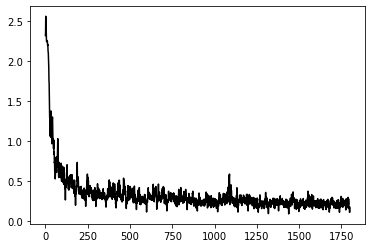

In [8]:
l1 = list(range(len(OFedAvg_loss)))


plt.plot(l1, OFedAvg_loss, 'black', label=r'OFedAvg ($\mathdefault{p=0.1}$)')


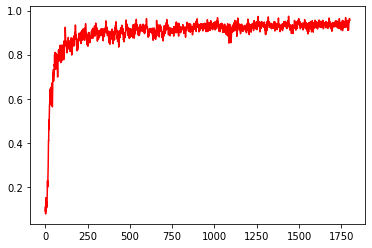

In [6]:
a1 = list(range(len(FedOGD_acc)))
a2 = list(range(len(OFedAvg_acc)))
plt.plot(a1, FedOGD_acc, 'black', label=r'OFedAvg ($\mathdefault{p=0.1}$)')
plt.plot(a2, OFedAvg_acc, 'red', label=r'OFedAvg ($\mathdefault{p=0.1}$)')

In [9]:
import pickle

with open(f"./OFedAvg_acc.pkl","wb") as f:
    pickle.dump(OFedAvg_acc, f)

with open(f"./OFedAvg_loss.pkl","wb") as f:
    pickle.dump(OFedAvg_loss, f)